In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
import warnings
warnings.filterwarnings('ignore')

# GLOBAL
nonDataCols = ['patient_id', 'sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)','patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)','patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']

> read data

In [2]:
raw_data = pd.read_excel('data/dataset.xlsx', engine="openpyxl")

raw_data.info()
raw_data.describe()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> data obeservation

,patient_age_quantile,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration (mchc),leukocytes,basophils,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
Total,0,5041,5041,5042,5045,5042,5042,5042,5042,5042,...,5617,5617,5617,5617,5617,5617,5617,5624,5624,5617
Percent,0.0,89.316088,89.316088,89.333806,89.38696,89.333806,89.333806,89.333806,89.333806,89.333806,...,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.645641,99.645641,99.521616
Types,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


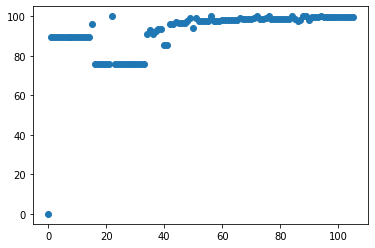

In [3]:
raw_data.columns = [x.lower().strip().replace(' ','_') for x in raw_data.columns]

def show_missing_features(x):
    total = x.isnull().sum()
    percent = (x.isnull().sum()/x.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in raw_data.columns:
        dtype = str(x[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

obs = show_missing_features(raw_data)
for x in nonDataCols:
    obs.drop(columns=[x], inplace=True)

[percent] = obs[1:2].values
plt.scatter([i for i in range(0, obs.shape[1])], percent)
obs.head()

> data cleaning

In [4]:
# Fill in missing features

for x in raw_data.columns:
    if raw_data[x].dtype=='float16' or  raw_data[x].dtype=='float32' or  raw_data[x].dtype=='float64':
        raw_data[x].fillna(raw_data[x].mean())

raw_data = raw_data.fillna(-999)

# Convert label-typed features
for y in raw_data.columns:
    if raw_data[y].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(raw_data[y].values))
        raw_data[y] = lbl.transform(list(raw_data[y].values))

raw_data.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,451,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,3669,8,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5457,5,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4843,15,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


> feature engineering

In [5]:
normalized_data = raw_data - raw_data.mean()

for x in nonDataCols:
    normalized_data.drop(columns=[x], inplace=True)

pca_size = 20
pca = PCA(n_components=pca_size)
pca.fit(normalized_data)

dataset = pd.DataFrame(pca.transform(normalized_data),
columns=['feature%s' % _ for _ in range(pca_size)],
index=raw_data.index)

for i, v in enumerate(nonDataCols):
    dataset.insert(i, v, raw_data[v])

dataset.head()

,patient_id,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",feature0,feature1,feature2,feature3,feature4,...,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19
0,1588,0,0,0,0,-459.185996,21.369325,-1.954074,-1.368605,-3.335151,...,0.711491,0.416025,0.283700,0.251134,0.027102,0.095836,0.158376,0.069797,0.087045,0.189939
1,451,0,0,0,0,3825.040571,-963.485107,-354.400607,23.375124,-1162.404300,...,111.234399,4.933126,-38.565040,54.115493,-64.459694,16.992792,-36.168855,-32.168891,-50.127985,11.060070
2,3669,0,0,0,0,-459.188455,21.369152,-1.948759,-1.370712,-3.330891,...,0.714949,0.414959,0.274832,0.253342,0.023134,0.101793,0.145677,0.059162,0.080810,0.199882
3,5457,0,0,0,0,-459.189931,21.369047,-1.945570,-1.371976,-3.328335,...,0.717023,0.414319,0.269511,0.254667,0.020753,0.105367,0.138057,0.052781,0.077069,0.205848
4,4843,0,0,0,0,-459.178808,21.372791,-1.957604,-1.365832,-3.343659,...,0.695108,0.411485,0.285917,0.251452,0.033547,0.088540,0.139204,0.074972,0.081150,0.179242


In [6]:
dataCols = [x for x in dataset.columns if x not in nonDataCols]
X = dataset[dataCols]
y = dataset['sars-cov-2_exam_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=101) # fixed random seed

> model training

In [7]:
# tune params with kfold
def TuneModelParams(model, name, params):
    print("Tuning", name, '...')
    score = make_scorer(accuracy_score)
    kfold = KFold(n_splits=10)
    grid = GridSearchCV(estimator=model, param_grid=params, scoring=score, cv=kfold)
    grid.fit(X_train, y_train)
    print('best score:', grid.best_score_)
    print('best params:')
    for key in params.keys():
        print(key, '=', grid.best_estimator_.get_params()[key])
    return grid

In [8]:
accuracy_list = []
default_acc_list = []
tuned_acc_list = []

#cv_acc_list = []

def model_assess(model, name='Default', prob='True'):
    # model.fit(X_train, y_train)
    print('Assess Model:', name)
    prds = model.predict(X_test)
    
    # accuracy
    model_acc = accuracy_score(y_test, prds)
    accuracy_list.append(100*model_acc)
    if name.startswith('Tuned'):
        tuned_acc_list.append(100*model_acc)
    else:
        default_acc_list.append(100*model_acc)
    print('Accuracy:', (accuracy_score(y_test, prds)))
    
    # cross validation
    #cv = cross_val_score(model, X_train, y_train, scoring='accuracy')
    #cv = cv.mean()
    #cv_acc_list.append(100*cv)

    if prob:
        prdProb_y = model.predict_proba(X_test)[:,1]
        print("ROC AUC:", roc_auc_score(y_test, prdProb_y))
    
    print(classification_report(y_test, prds, target_names=['neg', 'pos'])) # TODO
    sns.set()
    mat = confusion_matrix(y_test, prds)
    f, ax = plt.subplots()
    sns.heatmap(mat, annot=True, ax=ax)
    ax.set_title(name + ' Confusion Matrix')
    ax.set_xlabel('Predict')
    ax.set_ylabel('True')

> Random Forest

Assess Model: Random Forest
Accuracy: 0.8996242619431025
ROC AUC: 0.5934485638842485
              precision    recall  f1-score   support

         neg       0.91      0.99      0.95      1687
         pos       0.21      0.02      0.04       176

    accuracy                           0.90      1863
   macro avg       0.56      0.51      0.49      1863
weighted avg       0.84      0.90      0.86      1863

Tuning Random Forest ...
best score: 0.8973782300959081
best params:
min_samples_split = 4
min_samples_leaf = 2
bootstrap = True
Assess Model: Tuned Random Forest
Accuracy: 0.9033816425120773
ROC AUC: 0.5879267257638627
              precision    recall  f1-score   support

         neg       0.91      1.00      0.95      1687
         pos       0.30      0.02      0.03       176

    accuracy                           0.90      1863
   macro avg       0.60      0.51      0.49      1863
weighted avg       0.85      0.90      0.86      1863



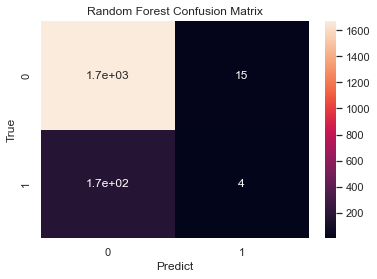

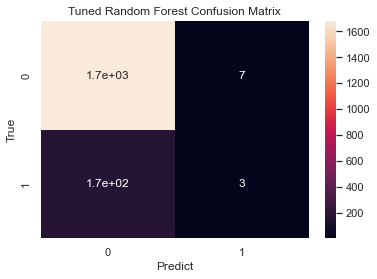

In [9]:
def RF():
    forest = RandomForestClassifier()
    forest.fit(X_train, y_train)
    return forest

def CV_RF():
    forest = RandomForestClassifier()
    params = {
        #'n_estimators': [10, 100, 500],
        #'max_depth': [10, 50, None],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }
    return TuneModelParams(forest, 'Random Forest', params)

model_assess(RF(), "Random Forest")

model_assess(CV_RF(), "Tuned Random Forest")

> Linear SVC

Assess Model: SVC
Accuracy: 0.831454643048846
              precision    recall  f1-score   support

         neg       0.91      0.90      0.91      1687
         pos       0.14      0.16      0.15       176

    accuracy                           0.83      1863
   macro avg       0.53      0.53      0.53      1863
weighted avg       0.84      0.83      0.84      1863

Tuning SVC ...
best score: 0.8994939341905039
best params:
penalty = l1
loss = squared_hinge
dual = False
max_iter = 100
Assess Model: Tuned SVC
Accuracy: 0.903918411164788
              precision    recall  f1-score   support

         neg       0.91      1.00      0.95      1687
         pos       0.33      0.02      0.03       176

    accuracy                           0.90      1863
   macro avg       0.62      0.51      0.49      1863
weighted avg       0.85      0.90      0.86      1863



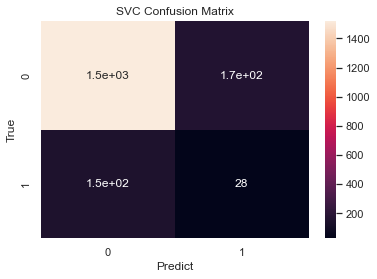

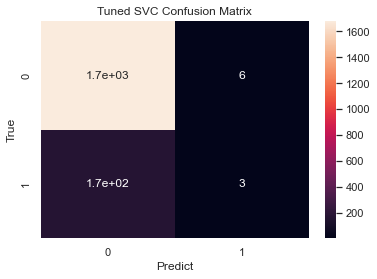

In [10]:
#svc = LinearSVC()
def SVC():
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    return svc

def CV_SVC():
    svc = LinearSVC()
    params = {
        'penalty': ['l1', 'l2'],
        'loss': ['hinge', 'squared_hinge'],
        'dual': [True, False],
        'max_iter': [100, 1000, None]
    }
    return TuneModelParams(svc, 'SVC', params)

model_assess(SVC(), "SVC", False)

model_assess(CV_SVC(), "Tuned SVC", False)

> K Nearest Neighbors

Assess Model: KNN
Accuracy: 0.9017713365539453
ROC AUC: 0.5185795791345583
              precision    recall  f1-score   support

         neg       0.91      0.99      0.95      1687
         pos       0.18      0.01      0.02       176

    accuracy                           0.90      1863
   macro avg       0.54      0.50      0.48      1863
weighted avg       0.84      0.90      0.86      1863

Tuning KNN ...
best score: 0.8989634376177911
best params:
n_neighbors = 50
leaf_size = 10
Assess Model: Tuned KNN
Accuracy: 0.90552871712292
ROC AUC: 0.5990697580427871
              precision    recall  f1-score   support

         neg       0.91      1.00      0.95      1687
         pos       0.00      0.00      0.00       176

    accuracy                           0.91      1863
   macro avg       0.45      0.50      0.48      1863
weighted avg       0.82      0.91      0.86      1863



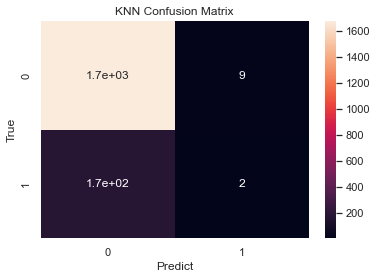

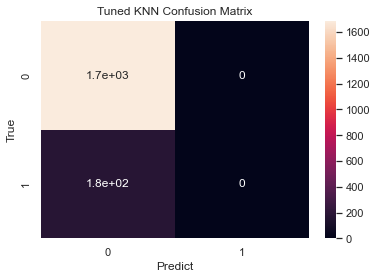

In [11]:
def KNN():
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    return knn

def CV_KNN():
    knn = KNeighborsClassifier()
    params = {
        'n_neighbors': [2, 5, 10, 50],
        'leaf_size': [10, 30, 100]
    }
    return TuneModelParams(knn, 'KNN', params)

model_assess(KNN(), "KNN")

model_assess(CV_KNN(), "Tuned KNN")

> comparison

In [12]:
# Demostrate model results on Train split
def acc_compare(model_list, acc_list, xl, yl='% of Accuracy', title='Accuracy of different Classifier Models'):
    default_model_list = ['RF', 'SVC', 'KNN']
    ax = sns.barplot(x=model_list, y = acc_list, palette = "coolwarm", saturation =2.0)
    plt.title(title, fontsize = 16)
    plt.xlabel(xl+' Models', fontsize = 12)
    plt.ylabel(yl, fontsize = 12)
    plt.xticks(fontsize = 12, horizontalalignment = 'center')
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
    plt.show

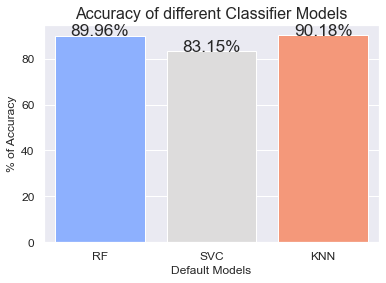

In [14]:
# Demostrate model results on Train split

default_model_list = ['RF', 'SVC', 'KNN']
tuned_model_list = ['Tuned RF', 'Tuned SVC', 'Tuned KNN']
all_model_list = ['RF', 'Tuned RF', 'SVC', 'Tuned SVC', 'KNN','Tuned KNN']

acc_compare(model_list=default_model_list, acc_list=default_acc_list ,xl='Default')

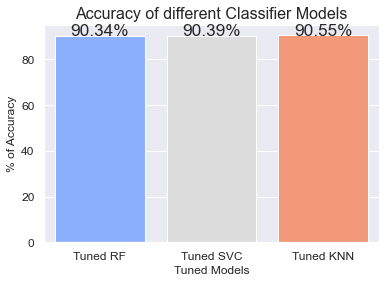

In [15]:
acc_compare(model_list=tuned_model_list, acc_list=tuned_acc_list, xl='Tuned')

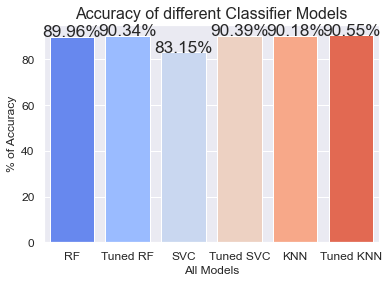

In [16]:
    acc_compare(model_list=all_model_list, acc_list=accuracy_list, xl='All')